Training and comparing results of PHSI, SINDy, BSI and SSINN on Hénon-Heiles system.  

In [85]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import pickle

In [86]:
#import from phsi
from phsi.phsystems import init_henon_heiles
from phsi.phnns import HSI, BaselineSI, generate_dataset, train, npoints_to_ntrajectories_tsample
ttype = torch.float32
torch.set_default_dtype(ttype)

In [87]:
#set up parameters
sampling_time = 1/10
integrator = 'srk4'
learning_rate = 1e-3
batch_size = 32
epochs = 60
l1_param_forces = 0.
l1_param_dissipation = 0.
prune_interval = 5
shuffle = True
noise_std = 0.
seed = 1
verbose = True
ntrajectories_val = 0

In [88]:
#load Henon-Heiles dataset
dataset = pickle.load(open("./models_comparison/ssinn/exp_henon_heiles/hh.pkl", "rb" ))
npoints = int(3000/0.8)
dataset = dataset[:npoints]
train_ = dataset[:int(0.8*len(dataset))]
val_ = dataset[int(0.8*len(dataset)):]
num_data_train = len(train_); num_data_val = len(val_)
train_start = torch.tensor([item[0][0].tolist() for item in train_])
train_end = torch.tensor([item[1][0].tolist() for item in train_])
val_start = torch.tensor([item[0][0].tolist() for item in val_])
val_end = torch.tensor([item[1][0].tolist() for item in val_])
t_start_train = torch.tensor([0]*(num_data_train+1))[:-1].reshape(-1,1)
t_end_train = torch.tensor([sampling_time]*(num_data_train+1))[1:].reshape(-1,1)
t_start_val = torch.tensor([0]*(num_data_val+1))[:-1].reshape(-1,1)
t_end_val =  torch.tensor([sampling_time]*(num_data_val+1))[1:].reshape(-1,1)
dt_train = torch.tensor([sampling_time]*num_data_train).reshape(-1,1)
dt_val = torch.tensor([sampling_time]*num_data_val).reshape(-1,1)
u_train = torch.zeros((num_data_train, len(train_start[0])))
u_val = torch.zeros((num_data_val, len(val_start[0])))
dxdt_train = (train_end - train_start)/sampling_time
dxdt_val = (val_end - val_start)/sampling_time

traindata = [(train_start, train_end, t_start_train, t_end_train, dt_train, u_train), dxdt_train]
valdata = [(val_start, val_end, t_start_val, t_end_val, dt_val, u_val), dxdt_train]
valdata = None

In [89]:
#load Henon-Heiles dataset with noise
dataset_noise = pickle.load(open("./models_comparison/ssinn/exp_henon_heiles/hh_noise.pkl", "rb" ))
npoints = int(3000/0.8)
dataset_noise = dataset_noise[:npoints]
train_ = dataset_noise[:int(0.8*len(dataset_noise))]
val_ = dataset_noise[int(0.8*len(dataset_noise)):]
num_data_train = len(train_); num_data_val = len(val_)
train_start = torch.tensor([item[0][0].tolist() for item in train_])
train_end = torch.tensor([item[1][0].tolist() for item in train_])
val_start = torch.tensor([item[0][0].tolist() for item in val_])
val_end = torch.tensor([item[1][0].tolist() for item in val_])
t_start_train = torch.tensor([0]*(num_data_train+1))[:-1].reshape(-1,1)
t_end_train = torch.tensor([sampling_time]*(num_data_train+1))[1:].reshape(-1,1)
t_start_val = torch.tensor([0]*(num_data_val+1))[:-1].reshape(-1,1)
t_end_val =  torch.tensor([sampling_time]*(num_data_val+1))[1:].reshape(-1,1)
dt_train = torch.tensor([sampling_time]*num_data_train).reshape(-1,1)
dt_val = torch.tensor([sampling_time]*num_data_val).reshape(-1,1)
u_train = torch.zeros((num_data_train, len(train_start[0])))
u_val = torch.zeros((num_data_val, len(val_start[0])))
dxdt_train = (train_end - train_start)/sampling_time
dxdt_val = (val_end - val_start)/sampling_time

traindata_noise = [(train_start, train_end, t_start_train, t_end_train, dt_train, u_train), dxdt_train]
valdata_noise = (val_start, val_end, t_start_val, t_end_val, dt_val, u_val), dxdt_train
valdata_noise = None

In [6]:
#set up PSHI model
function_space = np.array([1,0])   #first argument is polynomial terms, the second is trigonometric terms
hh_structure_matrix = np.array([
    [0, 0, 1, 0], [0, 0, 0, 1], [-1, 0, 0, 0], [0, -1, 0, 0]
])
nstates = 4
model_phsi = HSI(nstates, hh_structure_matrix, function_space, degrees=3)
model_phsi_noise = HSI(nstates, hh_structure_matrix, function_space, degrees=3)

optimizer = torch.optim.Adam(model_phsi.parameters(), lr=learning_rate, weight_decay=0)
optimizer_noise = torch.optim.Adam(model_phsi_noise.parameters(), lr=learning_rate, weight_decay=0)

In [7]:
#train PHSI model
phsi, vloss = train(model_phsi, integrator, traindata, optimizer, valdata=valdata, epochs=epochs,
                  batch_size=batch_size, shuffle=shuffle, l1_param_forces=l1_param_forces,
                  l1_param_dissipation=l1_param_dissipation, prune_val=prune_interval,
                  loss_fn=torch.nn.MSELoss(), verbose=verbose, return_best=True)

/Users/Sigurd/opt/anaconda3/lib/python3.8/site-packages/torch/autocast_mode.py:141: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')



Epoch 0
Training loss: 7.99e-02
Epoch training time: 5.59 seconds
x^[1 0 0 0]: 0.1137, x^[2 0 0 0]: 0.2739, x^[3 0 0 0]: 0.1179, x^[2 1 0 0]: 0.1511, x^[2 0 1 0]: 0.1243, 
x^[2 0 0 1]: 0.1228, x^[1 1 0 0]: 0.1258, x^[1 2 0 0]: 0.1204, x^[1 1 1 0]: 0.1963, x^[1 1 0 1]: 0.1946, 
x^[1 0 1 0]: 0.1404, x^[1 0 2 0]: 0.1185, x^[1 0 1 1]: 0.1809, x^[1 0 0 1]: 0.1427, x^[1 0 0 2]: 0.1182, 
x^[0 1 0 0]: 0.1143, x^[0 2 0 0]: 0.2624, x^[0 3 0 0]: 0.1129, x^[0 2 1 0]: 0.1198, x^[0 2 0 1]: 0.1164, 
x^[0 1 1 0]: 0.1327, x^[0 1 2 0]: 0.1229, x^[0 1 1 1]: 0.1842, x^[0 1 0 1]: 0.1288, x^[0 1 0 2]: 0.1236, 
x^[0 0 1 0]: 0.1150, x^[0 0 2 0]: 0.2817, x^[0 0 3 0]: 0.1158, x^[0 0 2 1]: 0.1237, x^[0 0 1 1]: 0.1307, 
x^[0 0 1 2]: 0.1261, x^[0 0 0 1]: 0.1141, x^[0 0 0 2]: 0.2828, x^[0 0 0 3]: 0.1180

Epoch 1
Training loss: 3.19e-02
Epoch training time: 5.14 seconds
x^[1 0 0 0]: 0.0544, x^[2 0 0 0]: 0.3268, x^[3 0 0 0]: 0.0598, x^[2 1 0 0]: 0.1904, x^[2 0 1 0]: 0.0697, 
x^[2 0 0 1]: 0.0671, x^[1 1 0 0]: 0.0751,

In [8]:
#train PHSI model on noisy data
phsi_noise, vloss_noise = train(model_phsi_noise, integrator, traindata_noise, optimizer_noise, valdata=valdata_noise, epochs=epochs,
                  batch_size=batch_size, shuffle=shuffle, l1_param_forces=l1_param_forces,
                  l1_param_dissipation=l1_param_dissipation, prune_val = prune_interval,
                  loss_fn=torch.nn.MSELoss(), verbose=verbose, return_best=True)


Epoch 0
Training loss: 1.59e-01
Epoch training time: 5.37 seconds
x^[1 0 0 0]: 0.1174, x^[2 0 0 0]: 0.2691, x^[3 0 0 0]: 0.1197, x^[2 1 0 0]: 0.1529, x^[2 0 1 0]: 0.1301, 
x^[2 0 0 1]: 0.1238, x^[1 1 0 0]: 0.1481, x^[1 2 0 0]: 0.1317, x^[1 1 1 0]: 0.1856, x^[1 1 0 1]: 0.2036, 
x^[1 0 1 0]: 0.1363, x^[1 0 2 0]: 0.1267, x^[1 0 1 1]: 0.1757, x^[1 0 0 1]: 0.1420, x^[1 0 0 2]: 0.1346, 
x^[0 1 0 0]: 0.1173, x^[0 2 0 0]: 0.2586, x^[0 3 0 0]: 0.1208, x^[0 2 1 0]: 0.1234, x^[0 2 0 1]: 0.1208, 
x^[0 1 1 0]: 0.1401, x^[0 1 2 0]: 0.1323, x^[0 1 1 1]: 0.1692, x^[0 1 0 1]: 0.1430, x^[0 1 0 2]: 0.1289, 
x^[0 0 1 0]: 0.1167, x^[0 0 2 0]: 0.2808, x^[0 0 3 0]: 0.1180, x^[0 0 2 1]: 0.1224, x^[0 0 1 1]: 0.1400, 
x^[0 0 1 2]: 0.1314, x^[0 0 0 1]: 0.1160, x^[0 0 0 2]: 0.2778, x^[0 0 0 3]: 0.1226

Epoch 1
Training loss: 1.12e-01
Epoch training time: 4.90 seconds
x^[1 0 0 0]: 0.0579, x^[2 0 0 0]: 0.3179, x^[3 0 0 0]: 0.0633, x^[2 1 0 0]: 0.1756, x^[2 0 1 0]: 0.0760, 
x^[2 0 0 1]: 0.0727, x^[1 1 0 0]: 0.1029,

In [9]:
#BSI setup
pol_space = True
trig_space = False
time_pol_space = False
time_trig_space = False
model_baselinesi = BaselineSI(nstates, degrees=2, pol_space=pol_space,\
    trig_space=trig_space, time_pol_space=time_pol_space, time_trig_space=time_trig_space)
model_baselinesi_noise = BaselineSI(nstates, degrees=2, pol_space=pol_space,\
    trig_space=trig_space, time_pol_space=time_pol_space, time_trig_space=time_trig_space)

optimizer_baselinesi = torch.optim.Adam(model_baselinesi.parameters(), lr=learning_rate, weight_decay=1e-4)
optimizer_baselinesi_noise = torch.optim.Adam(model_baselinesi_noise.parameters(), lr=learning_rate, weight_decay=1e-4)

In [10]:
#train BSI model
baselinesi, vloss_b = train(model_baselinesi, integrator, traindata, optimizer_baselinesi, valdata=valdata, epochs=epochs,
                  batch_size=batch_size, shuffle=shuffle, prune_val=20,
                  loss_fn=torch.nn.MSELoss(), verbose=verbose, return_best=True)


Epoch 0
Training loss: 1.08e-01
Epoch training time: 1.23 seconds
x1': x^[0, 0, 0, 0]: 0.1147, x^[1 0 0 0]: 0.1391, x^[2 0 0 0]: 0.1172, x^[1 1 0 0]: 0.2126, 
x^[1 0 1 0]: 0.1791, x^[1 0 0 1]: 0.1775, x^[0 1 0 0]: 0.1371, x^[0 2 0 0]: 0.1162, x^[0 1 1 0]: 0.1825, 
x^[0 1 0 1]: 0.1837, x^[0 0 1 0]: 0.2899, x^[0 0 2 0]: 0.1190, x^[0 0 1 1]: 0.1929, x^[0 0 0 1]: 0.1372, 
x^[0 0 0 2]: 0.1181, 

x2': x^[0, 0, 0, 0]: 0.1147, x^[1 0 0 0]: 0.1494, x^[2 0 0 0]: 0.1151, x^[1 1 0 0]: 0.2139, 
x^[1 0 1 0]: 0.1906, x^[1 0 0 1]: 0.1609, x^[0 1 0 0]: 0.1331, x^[0 2 0 0]: 0.1166, x^[0 1 1 0]: 0.1763, 
x^[0 1 0 1]: 0.1910, x^[0 0 1 0]: 0.1393, x^[0 0 2 0]: 0.1163, x^[0 0 1 1]: 0.1801, x^[0 0 0 1]: 0.2888, 
x^[0 0 0 2]: 0.1196, 

x3': x^[0, 0, 0, 0]: 0.1163, x^[1 0 0 0]: 0.1078, x^[2 0 0 0]: 0.1201, x^[1 1 0 0]: 0.2014, 
x^[1 0 1 0]: 0.1881, x^[1 0 0 1]: 0.1821, x^[0 1 0 0]: 0.1470, x^[0 2 0 0]: 0.1191, x^[0 1 1 0]: 0.1802, 
x^[0 1 0 1]: 0.1890, x^[0 0 1 0]: 0.1501, x^[0 0 2 0]: 0.1206, x^[0 0 1 1]: 0.

In [11]:
#train BSI model on noisy data
baselinesi_noise, vloss_bn = train(model_baselinesi_noise, integrator, traindata_noise, optimizer_baselinesi_noise, valdata=valdata, epochs=epochs,
                  batch_size=batch_size, shuffle=shuffle, prune_val=20,
                  loss_fn=torch.nn.MSELoss(), verbose=verbose, return_best=True)


Epoch 0
Training loss: 1.88e-01
Epoch training time: 1.17 seconds
x1': x^[0, 0, 0, 0]: 0.1197, x^[1 0 0 0]: 0.1553, x^[2 0 0 0]: 0.1268, x^[1 1 0 0]: 0.2097, 
x^[1 0 1 0]: 0.1978, x^[1 0 0 1]: 0.1765, x^[0 1 0 0]: 0.1458, x^[0 2 0 0]: 0.1209, x^[0 1 1 0]: 0.1928, 
x^[0 1 0 1]: 0.1844, x^[0 0 1 0]: 0.2854, x^[0 0 2 0]: 0.1262, x^[0 0 1 1]: 0.1874, x^[0 0 0 1]: 0.1665, 
x^[0 0 0 2]: 0.1220, 

x2': x^[0, 0, 0, 0]: 0.1167, x^[1 0 0 0]: 0.1499, x^[2 0 0 0]: 0.1209, x^[1 1 0 0]: 0.2178, 
x^[1 0 1 0]: 0.1851, x^[1 0 0 1]: 0.1992, x^[0 1 0 0]: 0.1346, x^[0 2 0 0]: 0.1213, x^[0 1 1 0]: 0.1727, 
x^[0 1 0 1]: 0.1973, x^[0 0 1 0]: 0.1529, x^[0 0 2 0]: 0.1229, x^[0 0 1 1]: 0.1869, x^[0 0 0 1]: 0.2826, 
x^[0 0 0 2]: 0.1250, 

x3': x^[0, 0, 0, 0]: 0.1185, x^[1 0 0 0]: 0.1113, x^[2 0 0 0]: 0.1273, x^[1 1 0 0]: 0.2173, 
x^[1 0 1 0]: 0.1860, x^[1 0 0 1]: 0.1871, x^[0 1 0 0]: 0.1459, x^[0 2 0 0]: 0.1227, x^[0 1 1 0]: 0.1919, 
x^[0 1 0 1]: 0.1849, x^[0 0 1 0]: 0.1625, x^[0 0 2 0]: 0.1216, x^[0 0 1 1]: 0.

In [12]:
#load SSINN model
from models_comparison.ssinn.ssinn import SSINN
from models_comparison.ssinn.function_spaces import bivariate_poly, gradient_wrapper
from models_comparison.ssinn.integrators import fourth_order
dict = torch.load("./models_comparison/ssinn/exp_henon_heiles/hh_model.pth")['state_dict']
ssinn = SSINN(gradient_wrapper(bivariate_poly(degree=3)), \
    gradient_wrapper(bivariate_poly(degree=3)), fourth_order)
ssinn.load_state_dict(dict)

<All keys matched successfully>

In [147]:
#load SSINN model with noise
from models_comparison.ssinn.ssinn import SSINN
from models_comparison.ssinn.function_spaces import bivariate_poly, gradient_wrapper
from models_comparison.ssinn.integrators import fourth_order
dict = torch.load("./models_comparison/ssinn/exp_henon_heiles/hh_noise_model.pth")['state_dict']
ssinn_noise = SSINN(gradient_wrapper(bivariate_poly(degree=3)), \
    gradient_wrapper(bivariate_poly(degree=3)), fourth_order)
ssinn_noise.load_state_dict(dict)
print(ssinn_noise.Tp.space.fc1.weight)

Parameter containing:
tensor([[ 6.4862e-04,  4.8404e-01,  4.0988e-14, -5.6586e-03,  4.4388e-01,
         -2.9380e-15, -5.6526e-03,  8.9416e-16, -3.9537e-15,  1.1904e-14,
          5.7034e-15,  2.1433e-16, -1.6353e-15,  4.0663e-15, -7.4361e-16]],
       requires_grad=True)


In [80]:
#SINDy setup
import pysindy as ps
from pysindy.feature_library.polynomial_library import PolynomialLibrary
from pysindy import SINDyDerivative, FiniteDifference, SmoothedFiniteDifference, SpectralDerivative
pH_system = init_henon_heiles()
damped_states = [False, False, False, False]
pH_system.seed(seed)
nstates = pH_system.nstates

s_dataset = []
s_dataset_noise = []
for i in range(3000-1):
    s_dataset.append(np.concatenate((dataset[i][0], dataset[i][1]), axis=0))
    s_dataset_noise.append(np.concatenate((dataset_noise[i][0], dataset_noise[i][1]), axis=0))


In [95]:
#train SINDy model
sindy_optm = ps.SR3(threshold=0.5, nu=1.0, max_iter=100)
sindy_library = PolynomialLibrary(degree=2, include_interaction=True)
sindy_model = ps.SINDy(optimizer = sindy_optm, feature_library=sindy_library, discrete_time=False, \
    feature_names=["qx", "qy", "px", "py"], differentiation_method=SINDyDerivative())
sindy_model.fit(s_dataset, t=0.1, multiple_trajectories=True)
sindy_model.print()

(qx)' = 0.998 px
(qy)' = 0.998 py
(px)' = -0.998 qx + -1.992 qx qy
(py)' = -0.998 qy + -0.996 qx^2 + 0.996 qy^2


In [129]:
#train SINDy model on noisy data
sindy_optm_noise = ps.SR3(threshold=0.5, nu=1.0, max_iter=100)
sindy_library = PolynomialLibrary(degree=2, include_interaction=True)
sindy_model_noise = ps.SINDy(optimizer = sindy_optm_noise, feature_library=sindy_library, discrete_time=False, \
    feature_names=["q1", "p1", "q2", "p2"], differentiation_method=SINDyDerivative())
sindy_model_noise.fit(s_dataset_noise, t=0.1, multiple_trajectories=True)
sindy_model_noise.print()

(q1)' = 0.995 q2
(p1)' = 0.948 p2
(q2)' = -1.025 q1 + -2.115 q1 p1
(p2)' = -0.975 p1 + -0.951 q1^2 + 0.944 p1^2


[0.1, -0.2, 0.4, 0.5]


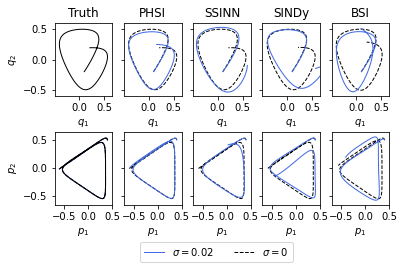

In [161]:
#plot trajectory
pH_system = init_henon_heiles()
damped_states = [False, False, False, False]
pH_system.seed(seed)
nstates = pH_system.nstates

t_sim = np.linspace(0, 8, 101)
t_sim_t = torch.tensor(t_sim)
x0 = [0.1, -0.2, 0.4, 0.5]
x_exact, dxdt, _, _ = pH_system.sample_trajectory(t_sim, x0)
nsamples = t_sim.shape[0]

x_phsi_noise, _ = phsi_noise.simulate_trajectory(integrator=False, t_sample=t_sim, x0=x0)
x_phsi, _ = phsi.simulate_trajectory(integrator=False, t_sample=t_sim, x0=x0)
x_baselinesi, _ = baselinesi.simulate_trajectory(integrator=False, t_sample=t_sim, x0=x0)
x_baselinesi_noise, _ = baselinesi_noise.simulate_trajectory(integrator=False, t_sample=t_sim, x0=x0)

x_ssinn_noise = np.zeros((101,4))
x_ssinn_noise[0] = x0
x_ssinn = np.zeros((101,4))
x_ssinn[0] = x0
for i in range(100):
    p0 = torch.tensor([x_ssinn[i, 2:]], requires_grad=True); q0 = torch.tensor([x_ssinn[i, :2]], requires_grad=True)
    p, q = ssinn(p0, q0, t_sim_t[i], t_sim_t[i+1])
    x_ssinn[i+1] = np.array(torch.squeeze(torch.cat((q, p), dim=1)).detach())

    p0_noise = torch.tensor([x_ssinn_noise[i, 2:]], requires_grad=True); q0_noise = torch.tensor([x_ssinn_noise[i, :2]], requires_grad=True)
    p_noise, q_noise = ssinn_noise(p0_noise, q0_noise, t_sim_t[i], t_sim_t[i+1])
    x_ssinn_noise[i+1] = np.array(torch.squeeze(torch.cat((q_noise, p_noise), dim=1)).detach())
x_sindy = sindy_model.simulate(x0, t_sim)
x_sindy_noise = sindy_model_noise.simulate(x0, t_sim)

x_exact = x_exact.reshape(-1, pH_system.nstates)
x_phsi = x_phsi.reshape(-1, pH_system.nstates)
x_phsi_noise = x_phsi_noise.reshape(-1, pH_system.nstates)
x_baselinesi = x_baselinesi.reshape(-1, pH_system.nstates)
x_baselinesi_noise = x_baselinesi_noise.reshape(-1, pH_system.nstates)

c1 = 'black'; c2 = 'royalblue'
fig, ax = plt.subplots(2, 5)
fig.set_size_inches(6,4)

xmin0 = min(x_exact[:,0]); xmin1 = min(x_exact[:,2])
xmax0 = max(x_exact[:,0]); xmax1 = max(x_exact[:,2])
ymin0 = min(x_exact[:,1]); ymin1 = min(x_exact[:,3])
ymax0 = max(x_exact[:,1]); ymax1 = max(x_exact[:,3])
spacex0 = (xmax0-xmin0)/10; spacex1 = (xmax1-xmin1)/10
spacey0 = (ymax0-ymin0)/10; spacey1 = (ymax1-ymin1)/10
for i in range(5):
    ax[0,i].set(xlim=(xmin0-spacex0, xmax0+spacex0), ylim=(ymin0-spacey0, ymax0+spacey0))
    ax[1,i].set(xlim=(xmin1-spacex1, xmax1+spacex1), ylim=(ymin1-spacey1, ymax1+spacey1))
for i in range(1, 5):
    ax[0,i].set_yticklabels([]); ax[1,i].set_yticklabels([])
    
ax[0,0].plot(x_exact[:, 0], x_exact[:, 1], linewidth=1, color=c1)
ax[0,1].plot(x_phsi[:, 0], x_phsi[:, 1], '--', linewidth=1, color=c1)
ax[0,1].plot(x_phsi_noise[:, 0], x_phsi_noise[:, 1], linewidth=1, color=c2)
ax[0,2].plot(x_ssinn[:, 0], x_ssinn[:, 1], '--', linewidth=1, color=c1)
ax[0,2].plot(x_ssinn_noise[:, 0], x_ssinn_noise[:, 1], linewidth=1, color=c2)
ax[0,3].plot(x_sindy[:, 0], x_sindy[:, 1], '--', linewidth=1, color=c1)
ax[0,3].plot(x_sindy_noise[:, 0], x_sindy_noise[:, 1], linewidth=1, color=c2)
ax[0,4].plot(x_baselinesi[:, 0], x_baselinesi[:, 1], '--', linewidth=1, color=c1)
ax[0,4].plot(x_baselinesi_noise[:, 0], x_baselinesi_noise[:, 1], linewidth=1, color=c2)
ax[1,0].plot(x_exact[:, 2], x_exact[:, 3], linewidth=1, color=c2, label='$\sigma = 0.02$')
ax[1,0].plot(x_exact[:, 2], x_exact[:, 3], '--', linewidth=1, color=c1, label='$\sigma = 0$')
ax[1,0].plot(x_exact[:, 2], x_exact[:, 3], linewidth=1, color = c1)
ax[1,1].plot(x_phsi[:, 2], x_phsi[:, 3], '--', linewidth=1, color=c1)
ax[1,1].plot(x_phsi_noise[:, 2], x_phsi_noise[:, 3], linewidth=1, color=c2)
ax[1,2].plot(x_ssinn[:, 2], x_ssinn[:, 3], '--', linewidth=1, color=c1)
ax[1,2].plot(x_ssinn_noise[:, 2], x_ssinn_noise[:, 3], linewidth=1, color=c2)
ax[1,3].plot(x_sindy[:, 2], x_sindy[:, 3], '--', linewidth=1, color=c1)
ax[1,3].plot(x_sindy_noise[:, 2], x_sindy_noise[:, 3], linewidth=1, color=c2)
ax[1,4].plot(x_baselinesi[:, 2], x_baselinesi[:, 3], '--', linewidth=1, color=c1)
ax[1,4].plot(x_baselinesi_noise[:, 2], x_baselinesi_noise[:, 3], linewidth=1, color=c2)

ax[1,0].legend(loc='center left', bbox_to_anchor=(1.4,-0.65), ncol=2)
for i in range(5):
    ax[0,i].set_xlabel('$q_1$')
    ax[1,i].set_xlabel('$p_1$')
ax[0,0].set_ylabel('$q_2$')
ax[1,0].set_ylabel('$p_2$')
ax[0,0].set_title('Truth')
ax[0,1].set_title('PHSI')
ax[0,2].set_title('SSINN')
ax[0,3].set_title('SINDy')
ax[0,4].set_title('BSI')
fig.subplots_adjust(bottom=0.25, hspace=0.5)
plt.savefig('plots/henon_heiles/hh_trajectory.pdf')
print(x0)

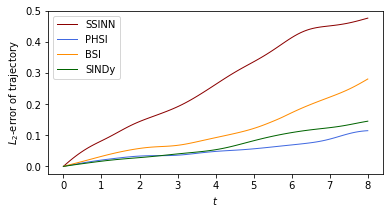

In [172]:
#position l2-error plot
sum_l2_phsi = np.zeros((nsamples))
sum_l2_ssinn = np.zeros((nsamples))
sum_l2_sindy = np.zeros((nsamples))
sum_l2_baselinesi = np.zeros((nsamples))
c_phsi = "royalblue"; c_baseline = "darkorange"; c_sindy = "darkgreen"; c_ssinn = "darkred"

t_sim = np.linspace(0, 8, 101)
t_sim_t = torch.tensor(t_sim)
nruns=10
for k in range(nruns):
    x_exact, dxdt, _, _ = pH_system.sample_trajectory(t_sim)
    x0 = x_exact[0, :]

    x_phsi_noise, _ = phsi_noise.simulate_trajectory(integrator=False, t_sample=t_sim, x0=x0)
    x_baselinesi_noise, _ = baselinesi_noise.simulate_trajectory(integrator=False, t_sample=t_sim, x0=x0)

    x_ssinn_noise = np.zeros((101,4))
    x_ssinn_noise[0] = x0
    for i in range(100):
        p0_noise = torch.tensor([x_ssinn_noise[i, 2:]], requires_grad=True); q0_noise = torch.tensor([x_ssinn_noise[i, :2]], requires_grad=True)
        p_noise, q_noise = ssinn_noise(p0_noise, q0_noise, t_sim_t[i], t_sim_t[i+1])
        x_ssinn_noise[i+1] = np.array(torch.squeeze(torch.cat((q_noise, p_noise), dim=1)).detach())

    x_sindy_noise = sindy_model_noise.simulate(x0, t_sim)

    x_exact = x_exact.reshape(-1, pH_system.nstates)
    x_phsi_noise = x_phsi_noise.reshape(-1, pH_system.nstates)
    x_baselinesi_noise = x_baselinesi_noise.reshape(-1, pH_system.nstates)

    sum_l2_phsi += np.sqrt(np.sum((x_exact - x_phsi_noise)**2, axis=1))
    sum_l2_ssinn += np.sqrt(np.sum((x_exact - x_ssinn_noise)**2, axis=1))
    sum_l2_sindy += np.sqrt(np.sum((x_exact - x_sindy_noise)**2, axis=1))
    sum_l2_baselinesi += np.sqrt(np.sum((x_exact - x_baselinesi_noise)**2, axis=1))


fig, ax = plt.subplots()
fig.set_size_inches(6,3)
ax.plot(t_sim, sum_l2_ssinn/nruns, label='SSINN', linewidth=1, color=c_ssinn)
ax.plot(t_sim, sum_l2_phsi/nruns, label='PHSI', linewidth=1, color=c_phsi)
ax.plot(t_sim, sum_l2_baselinesi/nruns, label='BSI', linewidth=1, color=c_baseline)
ax.plot(t_sim, sum_l2_sindy/nruns, label='SINDy', linewidth=1, color=c_sindy)
ax.set_xlabel('$t$')
ax.set_ylabel('$L_2$-error of trajectory')
ax.legend()
plt.savefig('plots/henon_heiles/hh_l2error.pdf')